# User agent rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Number of 'top domains'
n = 30

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

## Construct user agent to device matrix

In [6]:
def get_counts(ua, dev):
    if ua in useragents[dev]: return counts[(dev, ua)]
    return 0

datas = [ [ get_counts(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)
df["score"] = df.sum(axis=1)
df

,LAPTOP-1I501C4U,languid-mac,calcannea-cb,dramatic-mac,daniel-chromebook,mark-mac,calcannea-mac,boundless-mac,DESKTOP-PIMD8C0,theatergoing-mac,...,terrestrial-mac,traverses-mac,steamverne-mac,rarb-mac,essential-cb,turing-minimacbook,nervings-cb,simon-macpro,tirasse-mac,score
ACC_2.00.3024_1D121C0259B2E9EB,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
"server-bag [Mac OS X,10.13.4,1",0,2,0,30,0,0,0,0,0,0,...,0,4,0,0,0,2,0,18,0,77
Microsoft-Delivery-Optimizatio,5444,0,0,0,0,0,0,0,5444,52,...,0,0,0,0,0,0,0,0,0,10940
Advanced%20Mac%20Cleaner/1.14,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
Roblox/Darwin,0,0,0,52436,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,52436
amcuninstall/1.0 CFNetwork/897,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
dnf/2.7.5,0,0,0,0,0,20,0,139,0,16,...,0,0,0,0,0,0,0,0,0,182
X-Lite/5.2.0.90533 Mozilla/5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17
Mac OS X/10.13.5 (17F77),0,8,0,4,0,3,0,3,0,0,...,67,1,0,5,0,4,0,6,0,116
B3BB30A0-FD94-448B-976E-FC63EF,0,0,0,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30


## Get list of highest accessed user agents by all devices

In [7]:
top_uas = df.sort_values(by="score", ascending=False).index.values[:n]
top_uas

array(['Mozilla/5.0 (Macintosh; Intel ', 'Roblox/Darwin',
       'Mozilla/5.0 (X11; CrOS x86_64 ', 'Microsoft-Delivery-Optimizatio',
       'Mozilla/5.0 EA Download Manage', 'ProtoHttp 1.3/DS 15.1.2.3.0 (A',
       'python-requests/2.13.0', 'Mozilla/5.0 (X11; Ubuntu; Linu',
       'trustd (unknown version) CFNet', 'Mozilla/5.0 (Linux; Android 6.',
       'Mozilla/5.0 (Windows NT 10.0; ', 'Microsoft-WNS/10.0',
       'Debian APT-HTTP/1.3 (1.2.26)', 'MICROSOFT_DEVICE_METADATA_RETR',
       'ClamAV/0.100.0 (OS: darwin17.5', 'Mozilla/5.0 (Windows NT 6.1) A',
       'Microsoft-CryptoAPI/10.0', 'Safari/13605.2.8 CFNetwork/901',
       'Microsoft BITS/7.8', 'Windows-Update-Agent/10.0.1001',
       'server-bag [Mac OS X,10.13.5,1', 'dnf/2.7.5',
       'MacAppStore/2.4 (Macintosh; OS', 'Mac OS X/10.12.6 (16G1408)',
       'Microsoft BITS/7.5', 'server-bag [Mac OS X,10.12.6,1',
       'Dalvik/2.1.0 (Linux; U; Androi', 'Software%20Update (unknown ver',
       'Mac OS X/10.13.5 (17F77)', 'Microsof

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = len(a)
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = len(b)
        val = val * val
        
        tot += val
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite user agents by device

In [9]:
fav_uas = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_uas

[['LAPTOP-1I501C4U',
  array(['Microsoft-Delivery-Optimizatio', 'Mozilla/5.0 (Windows NT 10.0; ',
         'Microsoft-WNS/10.0', 'MICROSOFT_DEVICE_METADATA_RETR',
         'Microsoft-CryptoAPI/10.0', 'Microsoft BITS/7.8',
         'Windows-Update-Agent/10.0.1001', 'Microsoft NCSI',
         'Mozilla/4.0 (compatible; MSIE ', 'McHttpH',
         'ACC_2.00.3024_11D6185BEBA45BBE', 'WicaAgent',
         'Google Update/1.3.33.17;winhtt', 'ACC_2.00.3024_159CE2A505B94432',
         'ACC_2.00.3024_17F33DFE9BCBC137', 'ACC_2.00.3024_1A3C9AEC382A462E',
         'ACC__159FD869BF77544CE29', 'ACC_2.00.3024_14DEDD13CDF255FA',
         'ACC_2.00.3024_1C527FCD813E4FC6', 'ACC_2.00.3024_1D121C0259B2E9EB',
         'ACC_2.00.3024_15C2CD5AEC62D627', 'com.apple.trustd/1.0',
         'Roblox/212340 CFNetwork/897.15', 'Mozilla/5.0 (Macintosh; Intel ',
         'server-bag [Mac OS X,10.12.6,1', 'gamed/5.10.19.4.8.16.5.4.2 (Ma',
         'Roblox/217637 CFNetwork/897.15', '"Mozilla/5.0 (iPhone; CPU iPho',
       

In [10]:
df2 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
df2

,useragents
device,
LAPTOP-1I501C4U,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (..."
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (..."
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ..."
daniel-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ..."
mark-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
calcannea-mac,"[Mozilla/5.0 (Linux; Android 8., AndroidDownlo..."
boundless-mac,"[Mozilla/5.0 (Macintosh; Intel , Mozilla/5.0 (..."
DESKTOP-PIMD8C0,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["useragents"].apply(lambda x: spearman(x, top_uas)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["useragents", "coefficient"]]

,useragents,coefficient
device,,
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",-2.90
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",-2.91
terrestrial-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-3.05
turing-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",-3.12
rarb-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-3.15
ludicrous-mac,"[Mozilla/5.0 (Macintosh; Intel , server-bag [M...",-3.18
steamverne-mac,"[Mozilla/5.0 (X11; Ubuntu; Linu, Mozilla/5.0 (...",-3.25
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-3.34
minesweepers-mac,"[Mozilla/5.0 (Macintosh; Intel , ClamAV/0.100....",-3.38


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: spearman(uas, x)).round(2)

In [14]:
df3

,useragents,LAPTOP-1I501C4U,languid-mac,calcannea-cb,dramatic-mac,daniel-chromebook,mark-mac,calcannea-mac,boundless-mac,DESKTOP-PIMD8C0,...,ludicrous-mac,terrestrial-mac,traverses-mac,steamverne-mac,rarb-mac,essential-cb,turing-minimacbook,nervings-cb,simon-macpro,tirasse-mac
device,,,,,,,,,,,,,,,,,,,,,
LAPTOP-1I501C4U,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (...",1.00,-3.60,-3.36,-4.17,-3.38,-3.96,-3.68,-3.65,1.00,...,-3.66,-3.62,-3.63,-3.81,-3.87,-3.27,-3.97,-3.38,-3.80,-3.45
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-3.60,1.00,-2.24,-2.21,-2.19,-1.10,-2.34,-1.56,-3.60,...,-1.51,-1.16,-0.98,-1.73,-1.08,-2.21,-0.93,-2.19,-0.85,-1.94
calcannea-cb,"[Mozilla/5.0 (X11; CrOS x86_64 , Mozilla/5.0 (...",-3.36,-2.24,1.00,-3.46,0.49,-1.30,0.20,-2.76,-3.36,...,-0.51,-1.21,-0.74,-1.47,-0.41,0.85,-1.15,0.49,-1.11,0.22
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",-4.17,-2.21,-3.46,1.00,-3.46,-2.88,-3.39,-2.82,-4.17,...,-3.09,-2.73,-2.76,-3.40,-2.83,-3.47,-2.53,-3.46,-2.32,-3.22
daniel-chromebook,"[Mozilla/5.0 (X11; CrOS x86_64 , Dalvik/2.1.0 ...",-3.38,-2.19,0.49,-3.46,1.00,-1.25,0.03,-3.07,-3.38,...,-0.20,-1.14,-0.66,-1.47,-0.28,0.54,-0.89,1.00,-1.10,0.52
mark-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",-3.96,-1.10,-1.30,-2.88,-1.25,1.00,-1.38,-1.91,-3.96,...,-0.99,-0.73,-0.37,-0.87,-0.67,-1.30,-0.64,-1.25,-0.58,-1.00
calcannea-mac,"[Mozilla/5.0 (Linux; Android 8., AndroidDownlo...",-3.68,-2.34,0.20,-3.39,0.03,-1.38,1.00,-2.74,-3.68,...,-0.61,-1.23,-0.98,-1.50,-0.72,0.19,-1.17,0.03,-1.23,0.08
boundless-mac,"[Mozilla/5.0 (Macintosh; Intel , Mozilla/5.0 (...",-3.65,-1.56,-2.76,-2.82,-3.07,-1.91,-2.74,1.00,-3.65,...,-2.62,-1.83,-2.19,-2.33,-2.18,-2.81,-1.78,-3.07,-1.67,-2.78
DESKTOP-PIMD8C0,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (...",1.00,-3.60,-3.36,-4.17,-3.38,-3.96,-3.68,-3.65,1.00,...,-3.66,-3.62,-3.63,-3.81,-3.87,-3.27,-3.97,-3.38,-3.80,-3.45


In [15]:
## Don't need to calculate the log.

## Plot heatmap

In [16]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

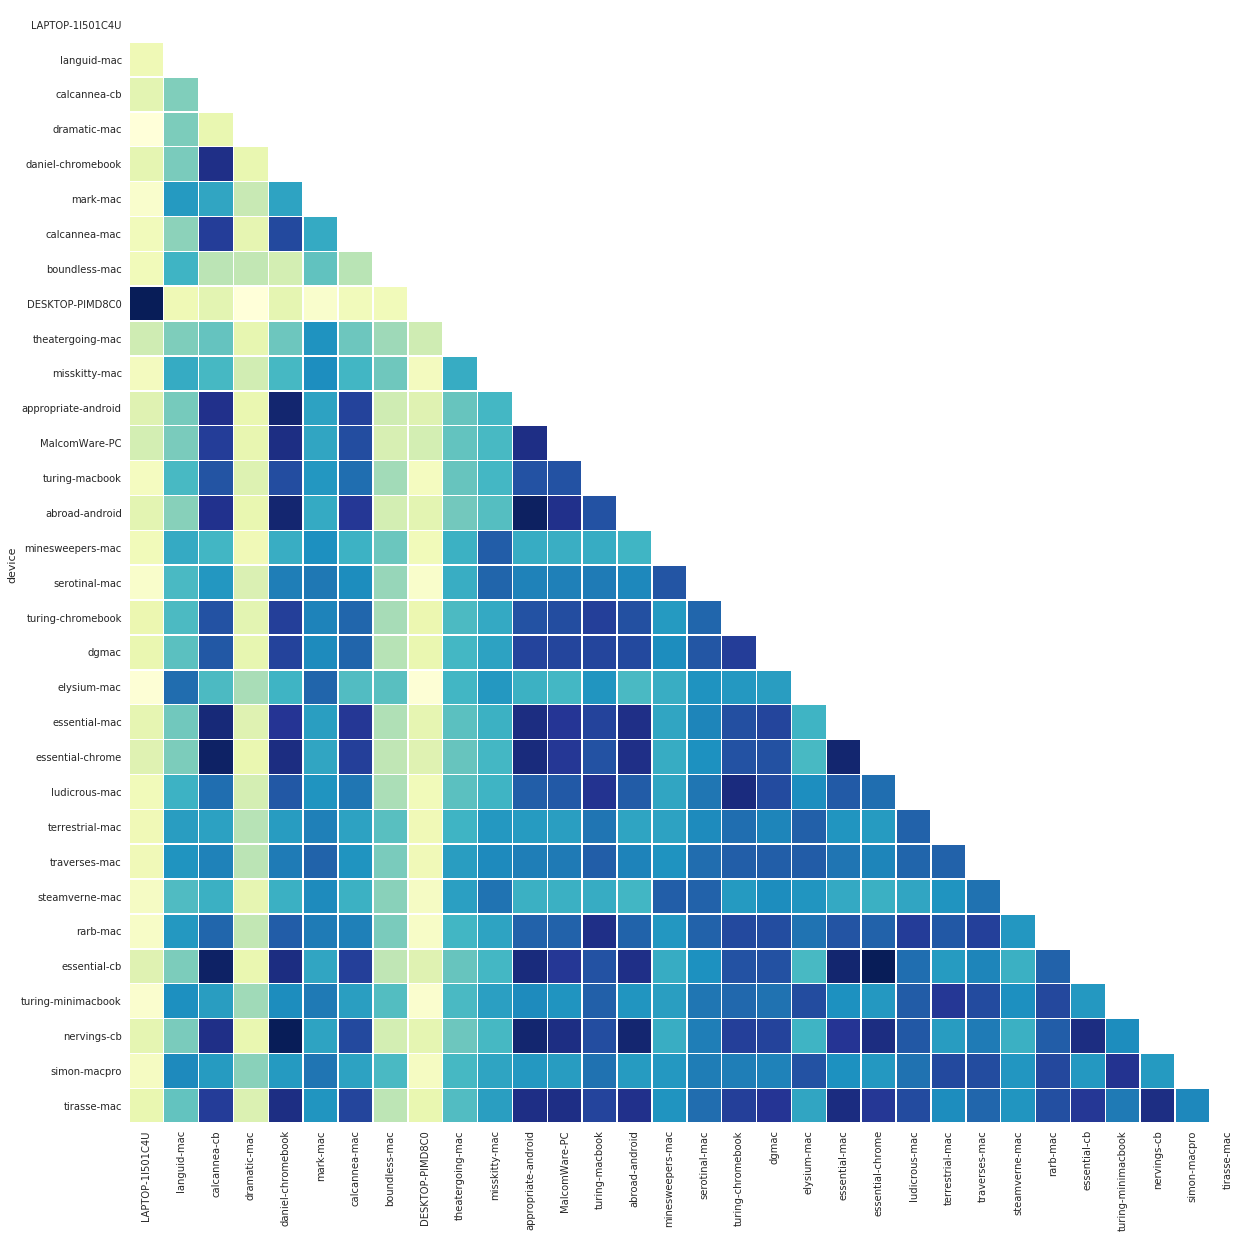

In [17]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, mask=mask, cmap="YlGnBu")
plt.show()